### Pre-setting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/home/r8user2/fastai/old')
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt

In [12]:
# Selected data
PATH = '/home/r8user2/Documents/HY/dress_data/alex_workplace/dressdata_project/git_workplace/selected_gd_data_5'
# Full data
#PATH = '/home/r8user2/Documents/HY/dress_data/datasets'
sz = 224

### Train Last Layer with Precompute = True

In [13]:
arch = resnet34
data = ImageClassifierData.from_paths(path = PATH,
                                      tfms = tfms_from_model(arch, sz),
                                      trn_name = 'imgtrain',
                                      val_name = 'imgval',
                                      # utilize CPUs in remote
                                      num_workers = 60)
learn = ConvLearner.pretrained(arch, data, precompute = True)

In [19]:
learn.fit(0.01, 20)

epoch      trn_loss   val_loss   accuracy                    
    0      0.394863   0.49501    0.811081  
    1      0.392159   0.489768   0.823097                    
    2      0.377      0.495159   0.81976                     
    3      0.364718   0.477104   0.823765                    
    4      0.343176   0.48859    0.82243                     
    5      0.349898   0.4896     0.826435                    
    6      0.325392   0.482423   0.827103                    
    7      0.321143   0.48716    0.821095                    
    8      0.318286   0.487332   0.837116                    
    9      0.29906    0.477597   0.8251                      
    10     0.305573   0.483416   0.831776                    
    11     0.295535   0.479046   0.825768                    
    12     0.302168   0.482174   0.829105                    
    13     0.293882   0.484321   0.825768                    
    14     0.297455   0.485628   0.837116                    
    15     0.268797   0.48

[array([0.47795]), 0.8331108140213308]

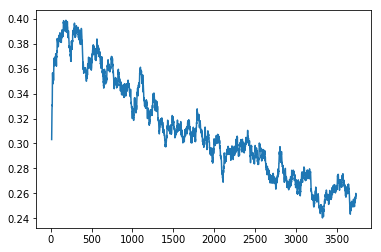

In [21]:
learn.sched.plot_loss()

### Find Optimal Learning Rate

In [22]:
lrf = learn.lr_find(1e-40,1e-2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.21999    0.482102   0.833111  



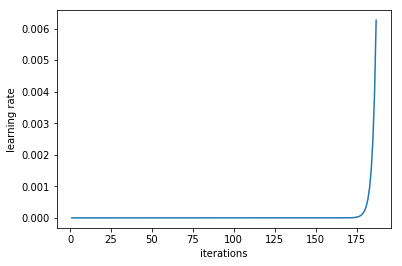

In [23]:
learn.sched.plot_lr()

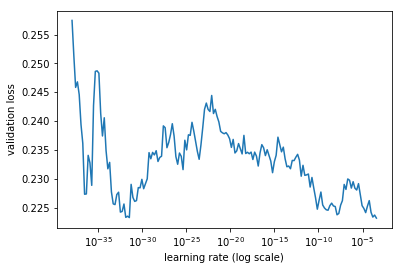

In [24]:
# From the graph, lr = 0.01 is appropriate
learn.sched.plot()

### Unfreeze and Learn Remaining Layers

In [25]:
learn.unfreeze()

In [26]:
lr = np.array([1e-36,1e-35,1e-34])
learn.fit(lr, 2, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.273733   0.478879   0.834446  
    1      0.250693   0.476436   0.833111                    
    2      0.272186   0.475944   0.832443                    



[array([0.47594]), 0.8324432572790077]

### Test Time Augmentation

In [28]:
log_preds, y = learn.TTA()

In [43]:
def accuracy_custom(preds, tags):
    preds_tags = np.argmax(preds, 1)
    n = len(tags)
    return sum(preds_tags == tags)/n

In [44]:
# Soft ensemble to aggregate augmented results
probs = np.mean(np.exp(log_preds), 0)
accuracy_custom(probs, y)

0.8364485981308412

In [45]:
# test set performance without TTA
log_preds_woTTA = learn.predict()
accuracy_custom(log_preds_woTTA, y)

0.8324432576769025

### Analysis of Results

In [46]:
# Construct confusion matrix
preds = np.argmax(probs, axis = 1)

In [47]:
preds_woTTA = np.argmax(log_preds_woTTA, 1)

[[218  45   8   2  25]
 [ 37 224   5   1  32]
 [  6   6 285   0   3]
 [  8   1   1 284   7]
 [ 31  21   2   4 242]]


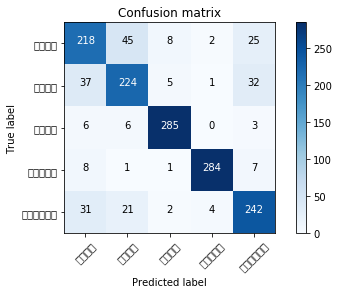

In [51]:
# Prediction with TTA
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes);

[[216  45   8   3  26]
 [ 37 225   5   2  30]
 [  7   6 284   0   3]
 [  6   2   2 283   8]
 [ 34  21   2   4 239]]


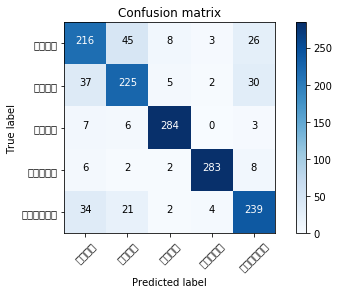

In [53]:
# Prediction without TTA
cm_woTTA = confusion_matrix(y, preds_woTTA);
plot_confusion_matrix(cm_woTTA, data.classes);